In [5]:
import os
import sys
import torch
import gpytorch
from tqdm.auto import tqdm
import timeit
import numpy as np
import pandas as pd
import scipy.special
from pathlib import Path
import seaborn as sns

if os.path.abspath('..') not in sys.path:
    sys.path.insert(0, os.path.abspath('..'))

device = "cuda:0" if torch.cuda.is_available() else None

sns.set(font_scale=1.25, style='whitegrid', palette=sns.color_palette("Set1"))

In [6]:
from torch.utils.cpp_extension import load

module_root = Path(os.path.abspath('')) / '..' / 'gpytorch_lattice_kernel'

def lazy_compile(is_cuda):
    if is_cuda:
        return load(name="gpu_lattice", verbose=True,
            sources=[
                module_root / 'lib' / 'permutohedral_cuda.cpp',
                module_root / 'lib' / 'permutohedral_cuda_kernel.cu'
            ]).filter
    else:
        return load(name="cpu_lattice", verbose=True,
            sources=[
                module_root / 'lattice.cpp'
            ]).filter

latticefilter = lazy_compile(torch.cuda.is_available())

Using /home/sanyam_s/.cache/torch_extensions as PyTorch extensions root...
No modifications detected for re-loaded extension module gpu_lattice, skipping build step...
Loading extension module gpu_lattice...


In [7]:
dpath = 'snelson.csv'
snel = pd.read_csv(dpath)
snel = snel.iloc[:100]#np.random.permutation(range(snel.shape[0]))[:100]]
snel_x = torch.from_numpy(snel.x.to_numpy()).unsqueeze(-1).float().to(device)
snel_y = torch.from_numpy(snel.y.to_numpy()).float().to(device)

In [8]:
def rel_err(x,y):
    return ((x-y)**2).mean().sqrt()/((x**2).mean().sqrt()+(y**2).mean().sqrt())

In [9]:
def binomial_coeffs(order):
    n = 2*order
    coeffs = torch.tensor([scipy.special.binom(n,i) for i in range(0,n+1)]).float()
    return coeffs/coeffs[order]

In [13]:
X = snel_x
f = snel_y[:,None]
#out = torch.zeros(1000000,16)
#print(lattice.testfunc(torch.ones((2,3))))
#src[:,-1] = torch.ones(1000)
# print(X)
# print(f)


In [35]:
from gpytorch.kernels import RBFKernel, MaternKernel

Kxx = torch.exp(-((X[None]-X[:,None])**2).sum(-1)/2)#/(2*np.pi)**(X.shape[-1]/2)
# Kxx = RBFKernel().to(device)(X, X)
mvm_gt = (Kxx @ f)

In [37]:
coeffs = torch.tensor([0.4398, 1.0000, 0.4398]).to(device)
coeffs = torch.tensor([0.1617, 0.6341, 1.0000, 0.6341, 0.1617]).to(device)
rel_err(mvm_gt,mvm_lattice/(mvm_lattice/mvm_gt).mean())

tensor(0.0223, device='cuda:0')

In [38]:
def gaussian_normalization(ell):
    # Integral of Gaussian covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2)

def matern_normalization(ell, nu):
    # Integral of Matern covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2) * gamma(nu + 0.5)/gamma(nu)/(nu**0.5)

def gaussian_covariance(x, ell=1.):
    x_normalized = x / ell
    return np.exp(-x_normalized**2/2)/gaussian_normalization(ell)

def matern_covariance(x, ell=1., nu=0.5):
    if np.isinf(nu): return gaussian_covariance(x,ell=ell)
    # Matern covariance with lengthscale ell    
    x[x == 0.0] += np.finfo(float).eps  # strict zeros result in nan
    x_normalized = np.sqrt(2*nu) * np.abs(x) / ell
    unnormalized_covar = (2**(1-nu) / gamma(nu)) * (x_normalized)**nu * kv(nu, x_normalized)
    return unnormalized_covar/matern_normalization(ell,nu)

def gaussian_coeffs(order,xmax):
    n = 2*order+1
    grid = np.linspace(-xmax,xmax,n)
    coeffs = gaussian_covariance(grid)
    coeffs /= coeffs[order]
    return torch.from_numpy(coeffs).float()

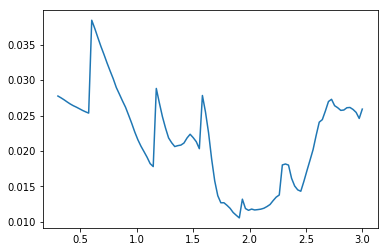

In [133]:
mvm_gt = Kxx@f
o=2

def err(coeffs):
    mvm_lattice = latticefilter(f,X,coeffs)
    return rel_err(mvm_gt,mvm_lattice/(mvm_lattice/mvm_gt).mean())

xmax = np.linspace(.3,3,100)
errs = [err(gaussian_coeffs(o,x)) for x in xmax]
sns.relplot(x=xmax,y=errs, kind='line')

In [128]:
print(f"Min of {np.min(errs):.3f} at {gaussian_coeffs(o,xmax[np.argmin(errs)])}")

Min of 0.011 at tensor([0.1617, 0.6341, 1.0000, 0.6341, 0.1617])


In [16]:
K = MaternKernel(nu=1.5)

In [17]:
x = torch.linspace(0,4,3).float()[:-1,None]

In [18]:
K(x,x).evaluate()[0]

tensor([1.0000, 0.0405], grad_fn=<SelectBackward>)

In [19]:
from gpytorch.kernels import RBFKernel

In [20]:
K = RBFKernel()
x = torch.linspace(0,2,3).float()[:-1,None]
K(x,x).evaluate()[0]

tensor([1.0000, 0.3532], grad_fn=<SelectBackward>)

In [24]:
for i in range(1,6):
    x = torch.arange(6).float()[:,None]/np.sqrt(i/2)
    print(K(x,x).evaluate()[0].data)

tensor([1.0000e+00, 1.2476e-01, 2.4227e-04, 7.3224e-09, 3.4448e-15, 2.5225e-23])
tensor([1.0000e+00, 3.5321e-01, 1.5565e-02, 8.5571e-05, 5.8693e-08, 5.0224e-12])
tensor([1.0000e+00, 4.9968e-01, 6.2340e-02, 1.9419e-03, 1.5103e-05, 2.9328e-08])
tensor([1.0000e+00, 5.9432e-01, 1.2476e-01, 9.2505e-03, 2.4227e-04, 2.2411e-06])
tensor([1.0000e+00, 6.5950e-01, 1.8917e-01, 2.3601e-02, 1.2807e-03, 3.0225e-05])
